In [91]:
import numpy as np
import pandas as pd

from glob import glob
from skimage import measure

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [92]:
data_path = "/home/samsmu/Data/Lung/CT"
working_path = data_path + "/DSB3_work"

In [93]:
def getRegionFromMap(slice_npy):
    thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
    label_image = measure.label(thr)
    labels = label_image.astype(int)
    regions = measure.regionprops(labels)
    return regions

def getRegionMetricRow(seg):
    # fname, numpy array of dimension [#slices, 1, 512, 512] containing the images
    nslices = seg.shape[0]
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    
    areas = []
    eqDiameters = []
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen])
        for region in regions:
            if region.area > maxAllowedArea:
                continue
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            avgEquivlentDiameter += region.equivalent_diameter
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
            
    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters)
    
    maxArea = max(areas)
    
    numNodesperSlice = numNodes*1. / nslices
    
    return np.array([avgArea ,maxArea,avgEcc,avgEquivlentDiameter,stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice])


In [15]:
file_list = glob(working_path + "/nodules*")

##Test
file_list = glob(working_path + "/nodules_c1481*") #39 slide

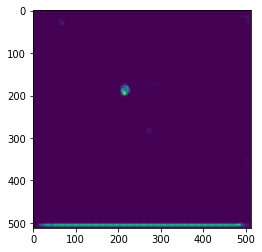

In [69]:
xs = np.load(file_list[-1])
image = xs[39]
plt.imshow(image)

Otsu thresh: 0.08720063


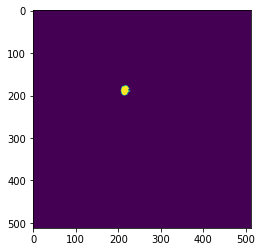

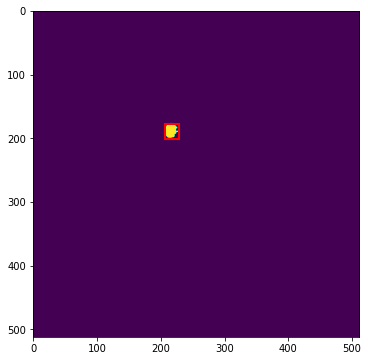

In [70]:
# apply threshold
image[500:,:] = 0
thresh = threshold_otsu(image)
print("Otsu thresh:", thresh)

thresh = 0.087
bw = closing(image > thresh,square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

plt.imshow(cleared)

# label image regions
label_image = label(cleared)
np.unique(label_image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(cleared)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
#image_label_overlay = label2rgb(label_image, image=image, bg_label=0)


In [89]:
xx = getRegionMetricRow(xs)


In [90]:
xx

array([1.32949087e+00, 7.10000000e+01, 7.20631188e-02, 1.21862420e+00,
       4.55758066e-01, 3.38828035e+02, 4.15061777e+02, 2.08200000e+03,
       3.35806452e+01])

In [73]:
from skimage import measure
slice_npy = image

thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
label_image = measure.label(thr)
labels = label_image.astype(int)
regions = measure.regionprops(labels)

totalArea = 0.
avgArea = 0.
maxArea = 0.
avgEcc = 0.
avgEquivlentDiameter = 0.
stdEquivlentDiameter = 0.
weightedX = 0.
weightedY = 0.

areas = []
eqDiameters = []
for region in regions:
    totalArea += region.area
    areas.append(region.area)
    avgEcc += region.eccentricity
    avgEquivlentDiameter += region.equivalent_diameter
    eqDiameters.append(region.equivalent_diameter)
    weightedX += region.centroid[0]*region.area
    weightedY += region.centroid[1]*region.area  

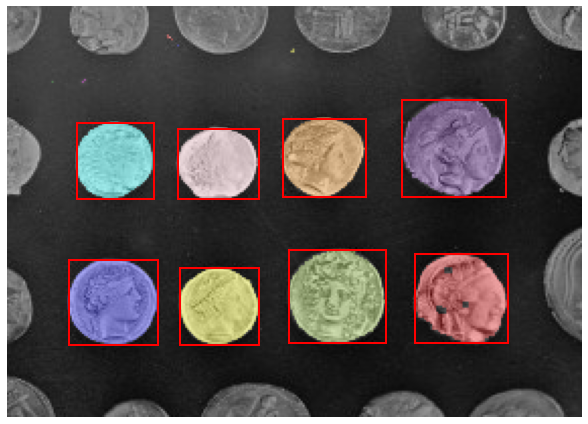

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

### Nodules extractor

In [ ]:
import SimpleITK as sitk

In [65]:



def createFeatureDataset(nodfiles=None):
    if nodfiles == None:
        # directory of numpy arrays containing masks for nodules
        # found via unet segmentation
        noddir = "/training_set/" 
        nodfiles = glob(noddir +"*npy")
    # dict with mapping between training examples and true labels
    # the training set is the output masks from the unet segmentation
    truthdata = pickle.load(open("truthdict.pkl",'r'))
    numfeatures = 9
    feature_array = np.zeros((len(nodfiles),numfeatures))
    truth_metric = np.zeros((len(nodfiles)))
    
    for i,nodfile in enumerate(nodfiles):
        patID = nodfile.split("_")[2]
        truth_metric[i] = truthdata[int(patID)]
        feature_array[i] = getRegionMetricRow(nodfile)
    
    np.save("dataY.npy", truth_metric)
    np.save("dataX.npy", feature_array)
    
def logloss(actual, predicted, eps=1e-14):

    """
    :param actual:      The binary labels. Either 0 or 1.  
    :param predicted:   The predicted probabilities as fl oats between 0-1
    :param eps:         Log(0) is equal to infinity, so we need to offset our predicted values slightly by eps from 0 or 1
    :return:            The logarithmic loss between between the predicted probability assigned to the possible outcomes for item i, and the actual outcome.
    """

    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1-predicted))

    return loss




In [27]:
### Classify

In [33]:
from sklearn.ensemble import RandomForestClassifier as RF

X = np.load("dataX.npy")
Y = np.load("dataY.npy")

kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print(classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred))

# All Cancer
print("Predicting all positive")
y_pred = np.ones(Y.shape)
print(classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred))

# No Cancer
print("Predicting all negative")
y_pred = Y*0
print(classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'dataX.npy'

In [30]:
from catboost import CatBoostClassifier as cat
# try catboost
print ("catboost")
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = cat(objective="binary:logistic")
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print (classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred))


catboost


NameError: name 'Y' is not defined